In [1]:
from typing import Any, Dict, List, Optional, Union

import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from bs4 import BeautifulSoup as bs
from lxml.html import fromstring

import pandas as pd
import numpy as np

import re
import unicodedata

import itertools
from copy import deepcopy

## custom libs

from korquanttools.pricevolume.config import PathConfig, ScraperConfig
from korquanttools.pricevolume.processor import Preprocessor, Lv2Converter
from korquanttools.pricevolume.utils import DateUtil

In [2]:
import investpy

In [3]:
years = list(range(2014, 2022))

yearly_from_to_list = [(f'01/01/{y}', f'01/12/{y}') for y in years]
yearly_from_to_list.append(('01/01/2022', '30/05/2022'))

## Economic calendar (macro)

In [4]:
earnings_calendar_df = []

for from_date, to_date in yearly_from_to_list:
    df = investpy.news.economic_calendar(from_date=from_date, to_date=to_date, countries=['south korea'])
    earnings_calendar_df.append(df)

earnings_calendar_df = pd.concat(earnings_calendar_df, ignore_index=True, )

In [5]:
earnings_calendar_df

,id,date,time,zone,currency,importance,event,actual,forecast,previous
0,9,01/01/2014,All Day,south korea,None,None,South Korea - New Year's Day,None,None,None
1,33077,01/01/2014,09:00,south korea,KRW,low,Trade Balance,3.70B,3.76B,4.80B
2,264342,01/01/2014,18:00,south korea,KRW,low,Exports (YoY) (Dec),6.90%,None,0.20%
3,233832,01/01/2014,18:00,south korea,KRW,low,Export Price Index (YoY) (Dec),-2.10%,None,-2.50%
4,259367,01/01/2014,18:00,south korea,KRW,low,Imports (YoY) (Dec),3.00%,None,-0.60%
...,...,...,...,...,...,...,...,...,...,...
2601,9,31/01/2022,All Day,south korea,None,None,South Korea - New Year's Day,None,None,None
2602,9,01/02/2022,All Day,south korea,None,None,South Korea - New Year's Day,None,None,None
2603,9,02/02/2022,All Day,south korea,None,None,South Korea - New Year's Day,None,None,None
2604,173,01/03/2022,All Day,south korea,None,None,South Korea - Independence Day,None,None,None


## Earnings Calendar (company)

In [4]:
REQUEST_URL = 'https://www.investing.com/earnings-calendar/Service/getCalendarFilteredData'

REQUEST_HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36",
    "X-Requested-With": "XMLHttpRequest",
    "Accept": "text/html",
    "Accept-Encoding": "gzip, deflate",
    "Connection": "keep-alive",
}

In [74]:
class EarningsCalandarDataFetcher:
    def __init__(self) -> None:
        ## Init config
        self.scraper_config = ScraperConfig()
        
        ## Init session
        self.session = requests.session()

        assert_status_hook = lambda response, *args, **kwargs: response.raise_for_status()
        self.session.hooks["response"] = [assert_status_hook]

        retry_strategy = Retry(**self.scraper_config.retry_strategy)
        adapter = HTTPAdapter(max_retries=retry_strategy)

        self.session.mount("http://", adapter)
        self.session.mount("https://", adapter)
        
        ## POST data
        self.request_url = REQUEST_URL
        self.request_headers = REQUEST_HEADERS
        self.POST_data = {
            "country[]": "11", # south korea
            "dateFrom": None,
            "dateTo": None,
            "currentTab": "custom",
            "limit_from": "0",
            "submitFilters": "1",
            # "last_time_scope": "1437523200",
            # "byHandler": "true",
            }
        
        ## Parsing data
        weekdays = [
            'Monday',
            'Tuesday',
            'Wednesday',
            'Thursday',
            'Friday',
            'Saturday',
            'Sunday',
        ]

        self.weekdays_re = re.compile('(' + '|'.join(weekdays) + ')')
        self.space_re = re.compile('^\s*$')

    def get_response(self, from_date, to_date):
        self.POST_data['dateFrom'] = from_date # "2022-01-01"
        self.POST_data['dateTo'] = to_date # "2022-05-30"

        res = self.session.post(self.request_url, data=self.POST_data, headers=self.request_headers)

        return res

    def parse_earnings_text(self, root_bs_text):
        split = root_bs_text.split('\n')
        split = [s for s in split if not re.match(self.space_re, s)]
        split = [unicodedata.normalize('NFKD', s) for s in split ]

        split_idx = []
        for idx, item in enumerate(split):
            if re.search(self.weekdays_re, item):
                split_idx.append(idx)
        
        data_list = []
        for start_idx, end_idx in zip(split_idx, split_idx[1:] + [None]):
            data_text_list = split[start_idx:end_idx]
            
            date = data_text_list.pop(0)
            
            for idx in range(0, len(data_text_list), 6):
                data_text = data_text_list[idx:idx+6]
                data = {
                    'date': date, # Tuesday, January 4, 2022
                    'company': data_text[0], # K Auction (102370)
                    'EPS' : data_text[1], # 606.73
                    'EPS_forecast': data_text[2], # /  --
                    'revenue': data_text[3], # 14.39B
                    'revenue_forecast': data_text[4], # /  --
                }

                data_list.append(data)

        return data_list

    def parse_response(self, res):
        root_bs = bs(res.json()['data'], 'html.parser')
        root_text = root_bs.get_text()

        data_list = self.parse_earnings_text(root_text)

        return data_list

    def get_data(self, start_year, end_year, additional_from_to_list=[]):
        years = list(range(start_year, end_year))
        yearly_from_to_list = [(f'{y}-01-01', f'{y}-12-31') for y in years]
        yearly_from_to_list += additional_from_to_list

        all_data_list = []
        for from_date, to_date in yearly_from_to_list:
            res = self.get_response(from_date, to_date)
            data_list = self.parse_response(res)
            all_data_list += data_list
        
        return all_data_list
    
    def preprocess_data(self, data_list):
        earnings_calendar_df = pd.DataFrame(data_list)

        earnings_calendar_df.loc[:, 'date'] = earnings_calendar_df.loc[:, 'date'].apply(self.parse_date)
        earnings_calendar_df.loc[:, 'codename'] = earnings_calendar_df.loc[:, 'company'].apply(lambda x: self.parse_company(x)[0])
        earnings_calendar_df.loc[:, 'sid'] = earnings_calendar_df.loc[:, 'company'].apply(lambda x: self.parse_company(x)[1])
        earnings_calendar_df.loc[:, 'EPS'] = earnings_calendar_df.loc[:, 'EPS'].apply(self.parse_value)
        earnings_calendar_df.loc[:, 'EPS_forecast'] = earnings_calendar_df.loc[:, 'EPS_forecast'].apply(self.parse_value)
        earnings_calendar_df.loc[:, 'revenue'] = earnings_calendar_df.loc[:, 'revenue'].apply(self.parse_value)
        earnings_calendar_df.loc[:, 'revenue_forecast'] = earnings_calendar_df.loc[:, 'revenue_forecast'].apply(self.parse_value)
    
        earnings_calendar_df.drop('company', axis=1, inplace=True)

        return earnings_calendar_df
    
    @staticmethod
    def parse_date(investings_date):
        investings_date = investings_date.strip()
        format = "%A, %B %d, %Y"
        
        return pd.to_datetime(investings_date, format=format)
    
    @staticmethod
    def parse_company(company_str):
        pattern_re = re.compile('(.+)\((\d{6})\)')
        codename = re.search(pattern_re, company_str)[1]
        sid = re.search(pattern_re, company_str)[2]

        return codename, sid
    
    @staticmethod
    def parse_value(value):
        multiplier = 1
        
        if 'B' in value:
            value = value.replace('B', '')
            multiplier = 1e+9
        elif 'T' in value:
            value = value.replace('T', '')
            multiplier = 1e+12
        elif 'M' in value:
            value = value.replace('M', '')
            multiplier = 1e+6
        
        value = value.replace('/', '')
        value = value.replace(',', '')
        value = value.strip()
        
        try:
            value = float(value)
            
            return value * multiplier
        
        except:
            return None

In [75]:
fetcher = EarningsCalandarDataFetcher()

In [76]:
data_list = fetcher.get_data(2014, 2022, additional_from_to_list=[('2022-01-01', '2022-05-30')])

In [77]:
earnings_calendar_df = pd.DataFrame(data_list)

earnings_calendar_df.loc[:, 'date'] = earnings_calendar_df.loc[:, 'date'].apply(fetcher.parse_date)
earnings_calendar_df.loc[:, 'codename'] = earnings_calendar_df.loc[:, 'company'].apply(lambda x: fetcher.parse_company(x)[0])
earnings_calendar_df.loc[:, 'sid'] = earnings_calendar_df.loc[:, 'company'].apply(lambda x: fetcher.parse_company(x)[1])
earnings_calendar_df.loc[:, 'EPS'] = earnings_calendar_df.loc[:, 'EPS'].apply(fetcher.parse_value)
earnings_calendar_df.loc[:, 'EPS_forecast'] = earnings_calendar_df.loc[:, 'EPS_forecast'].apply(fetcher.parse_value)
earnings_calendar_df.loc[:, 'revenue'] = earnings_calendar_df.loc[:, 'revenue'].apply(fetcher.parse_value)
earnings_calendar_df.loc[:, 'revenue_forecast'] = earnings_calendar_df.loc[:, 'revenue_forecast'].apply(fetcher.parse_value)

earnings_calendar_df.drop('company', axis=1, inplace=True)

<AxesSubplot:>

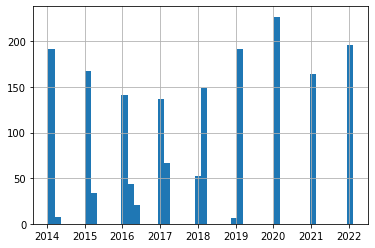

In [78]:
earnings_calendar_df['date'].hist(bins=50) # TODO: 연초만 있네... 일부만 가져온 것이 확실하다. 

In [79]:
earnings_calendar_df.to_pickle(f'earnings_calendar_20140101-20220530.pickle')

In [80]:
len(earnings_calendar_df)

1797

In [81]:
earnings_calendar_df

,date,EPS,EPS_forecast,revenue,revenue_forecast,codename,sid
0,2014-01-16,NaN,972.88,NaN,9.403600e+11,KT&G Corp,033780
1,2014-01-20,-37.00,NaN,NaN,6.091100e+11,Hotel Shilla,008770
2,2014-01-21,NaN,1224.00,NaN,4.110000e+12,Hyundai Engineering & Const,000720
3,2014-01-21,NaN,NaN,NaN,3.064000e+11,Lotte Fine Chemical,004000
4,2014-01-21,NaN,932.50,NaN,NaN,Korea Line,005880
...,...,...,...,...,...,...,...
1792,2022-02-08,233.08,NaN,9.697000e+10,NaN,Dae Hyun,016090
1793,2022-02-08,-57.88,NaN,1.135000e+11,NaN,S Net Systems,038680
1794,2022-02-08,1168.00,NaN,4.030000e+10,3.250000e+10,Dong A Eltek,088130
1795,2022-02-08,338.13,NaN,3.074000e+10,NaN,DT&C,187220


In [33]:
start = '2022-01-01'
end = '2022-05-30'

In [35]:
dl = fetcher.get_data(2022, 2022, additional_from_to_list=[(start, end)])

In [36]:
df = pd.DataFrame(dl)

df.loc[:, 'date'] = df.loc[:, 'date'].apply(fetcher.parse_date)
df.loc[:, 'codename'] = df.loc[:, 'company'].apply(lambda x: fetcher.parse_company(x)[0])
df.loc[:, 'sid'] = df.loc[:, 'company'].apply(lambda x: fetcher.parse_company(x)[1])
df.loc[:, 'EPS'] = df.loc[:, 'EPS'].apply(fetcher.parse_value)
df.loc[:, 'EPS_forecast'] = df.loc[:, 'EPS_forecast'].apply(fetcher.parse_value)
df.loc[:, 'revenue'] = df.loc[:, 'revenue'].apply(fetcher.parse_value)
df.loc[:, 'revenue_forecast'] = df.loc[:, 'revenue_forecast'].apply(fetcher.parse_value)

df.drop('company', axis=1, inplace=True)

In [37]:
df

,date,EPS,EPS_forecast,revenue,revenue_forecast,codename,sid
0,2022-01-04,55.85,NaN,5.170000e+09,NaN,K Auction,102370
1,2022-01-05,-36.95,NaN,3.330000e+09,NaN,EGtronics,377330
2,2022-01-06,921.92,NaN,6.707000e+10,NaN,Narae NanoTech,137080
3,2022-01-10,-206.72,NaN,NaN,NaN,Skonec Entertainment,276040
4,2022-01-14,84.05,NaN,9.000000e+09,NaN,Assems,136410
5,2022-01-20,1121.48,1325.48,1.247500e+12,1.226250e+12,KT&G Corp,033780
6,2022-01-21,-506.69,NaN,2.860000e+11,NaN,Daedong Ind,000490
7,2022-01-24,2965.78,4291.38,4.443000e+11,4.442500e+11,Samsung Biologics,207940
8,2022-01-25,2112.00,2381.61,3.102600e+13,3.027938e+13,Hyundai,005389
9,2022-01-26,1566.00,1627.65,7.657000e+13,7.554709e+13,Samsung Electronics Co Pref,005935


In [20]:
res = fetcher.get_response(start, end)

In [25]:
res_json = res.json()
res_json.keys()

dict_keys(['data', 'timeframe', 'dateFrom', 'dateTo', 'rows_num', 'last_time_scope', 'bind_scroll_handler', 'pairsToRegister'])

In [26]:
res_json['timeframe']

'custom'

In [29]:
res_json['rows_num']

225

In [30]:
res_json['last_time_scope']

1644278400

In [31]:
res_json['bind_scroll_handler']

True

In [49]:
pairsToRegister = res_json['pairsToRegister']
l = pairsToRegister[2:-2].split(',')

In [51]:
len(l)

197

In [44]:
bs_text = bs(res_json['data'], 'html.parser').get_text()

In [57]:
space_re = re.compile('^\s*$')

weekdays = [
    'Monday',
    'Tuesday',
    'Wednesday',
    'Thursday',
    'Friday',
    'Saturday',
    'Sunday',
]

weekdays_re = re.compile('(' + '|'.join(weekdays) + ')')

In [ ]:

split = bs_text.split('\n')
split = [s for s in split if not re.match(space_re, s)]
split = [unicodedata.normalize('NFKD', s) for s in split ]

In [72]:
split_idx = []
for idx, item in enumerate(split):
    if re.search(weekdays_re, item):
        split_idx.append(idx)

dtl_l = []

data_list = []
for start_idx, end_idx in zip(split_idx, split_idx[1:] + [None]):
    data_text_list = split[start_idx:end_idx]
    
    dtl_l.append(data_text_list)

    date = data_text_list.pop(0)
    
    for idx in range(0, len(data_text_list), 6):
        data_text = data_text_list[idx:idx+6]
        data = {
            'date': date, # Tuesday, January 4, 2022
            'company': data_text[0], # K Auction (102370)
            'EPS' : data_text[1], # 606.73
            'EPS_forecast': data_text[2], # /  --
            'revenue': data_text[3], # 14.39B
            'revenue_forecast': data_text[4], # /  --
        }

        data_list.append(data)

In [73]:
data_list

[{'date': 'Tuesday, January 4, 2022',
  'company': 'K Auction (102370)',
  'EPS': '-128.24',
  'EPS_forecast': '/  --',
  'revenue': '10.51B',
  'revenue_forecast': '/  --'},
 {'date': 'Wednesday, January 5, 2022',
  'company': 'EGtronics (377330)',
  'EPS': '-100.07',
  'EPS_forecast': '/  --',
  'revenue': '5.44B',
  'revenue_forecast': '/  --'},
 {'date': 'Thursday, January 6, 2022',
  'company': 'Narae NanoTech (137080)',
  'EPS': '435.54',
  'EPS_forecast': '/  --',
  'revenue': '37.40B',
  'revenue_forecast': '/  --'},
 {'date': 'Monday, January 10, 2022',
  'company': 'Skonec Entertainment (276040)',
  'EPS': '-304.94',
  'EPS_forecast': '/  --',
  'revenue': '2.71B',
  'revenue_forecast': '/  --'},
 {'date': 'Friday, January 14, 2022',
  'company': 'Assems (136410)',
  'EPS': '9.67',
  'EPS_forecast': '/  --',
  'revenue': '9.95B',
  'revenue_forecast': '/  --'},
 {'date': 'Friday, January 14, 2022',
  'company': 'Pungkang (093380)',
  'EPS': '-0.31',
  'EPS_forecast': '/  --',